In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [9]:
gc.collect()

7

In [10]:
#show_data(data,columns, 1,480, None)

In [11]:
#show_data2(data,columns)

# cv

In [12]:
n_reg_lookback=28

In [13]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [14]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [15]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'
                   ])

In [16]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [17]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [18]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [19]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [20]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [21]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [22]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [27]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l4_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [28]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [29]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l4_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1532
0
26 36 (1, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2800 - total_loss: 0.2800 - reg_loss: 0.2800 - val_loss: 0.2490 - val_total_loss: 0.2490 - val_reg_loss: 0.2490
Epoch 2/100
1532/1532 [==============================] - 18s 12ms/step - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909882  0.019228  0.226206    7  2017-04-16
472     2.507290  2.542308 -0.035018  0.231543    1  2017-04-17
473     2.661330  2.684054 -0.022724  0.247314    2  2017-04-18
474     2.754815  2.746961  0.007854  0.199511    3  2017-04-19
475     2.713762  2.713627  0.000134  0.227536    4  2017-04-20
476     2.999000  2.993257  0.005743  0.150927    5  2017-04-21
477     3.075529  3.082221 -0.006692  0.181979    6  2017-04-22

0.2092876662
best_epochs [6, 3, 10, 5, 11]
(829, 1) 2.64939592098 

2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195972, 2) (49031, 2)
train/valid # (195972, 2) (49031, 2)
rand split across time
train has 195972 records out of 372221 records
valid has 49031 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1531
0
26 36 (2, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1531/1531 [==============================] - 20s 13ms/step - loss: 0.2889 - total_loss: 0.2889 - reg_loss: 0.2889 - val_loss: 0.2668 - val_total_loss: 0.2668 - val_reg_loss: 0.2668
Epoch 2/100
1531/1531 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.930621 -0.001511  0.236103    6  2017-04-15
471     2.507290  2.548190 -0.040900  0.230377    7  2017-04-16
472     2.661330  2.685934 -0.024605  0.248700    1  2017-04-17
473     2.754815  2.741317  0.013498  0.211770    2  2017-04-18
474     2.713762  2.728635 -0.014873  0.233832    3  2017-04-19
475     2.999000  3.004614 -0.005614  0.153304    4  2017-04-20
476     3.075529  3.095311 -0.019781  0.184655    5  2017-04-21

0.214105705957
best_epochs [5, 6, 9, 7, 8]
(829, 1) 2.54417749081 

3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195805, 2) (48983, 2)
train/valid # (195805, 2) (48983, 2)
rand split across time
train has 195805 records out of 372221 records
valid has 48983 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1529
0
26 36 (3, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1529/1529 [==============================] - 30s 19ms/step - loss: 0.2918 - total_loss: 0.2918 - reg_loss: 0.2918 - val_loss: 0.2529 - val_total_loss: 0.2529 - val_reg_loss: 0.2529
Epoch 2/100
1529/1529 [==============================] - 28s 19ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.910604  0.018506  0.238833    5  2017-04-14
470     2.507290  2.540655 -0.033364  0.235861    6  2017-04-15
471     2.661330  2.657195  0.004135  0.262411    7  2017-04-16
472     2.754815  2.758400 -0.003585  0.217248    1  2017-04-17
473     2.713762  2.715058 -0.001296  0.239671    2  2017-04-18
474     2.999000  3.008075 -0.009075  0.158106    3  2017-04-19
475     3.075529  3.080170 -0.004640  0.187277    4  2017-04-20

0.219915292124
best_epochs [4, 7, 3, 6, 5]
(829, 1) 2.64029275433 

4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195621, 2) (48937, 2)
train/valid # (195621, 2) (48937, 2)
rand split across time
train has 195621 records out of 372221 records
valid has 48937 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1528
0
26 36 (4, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1528/1528 [==============================] - 29s 19ms/step - loss: 0.2907 - total_loss: 0.2907 - reg_loss: 0.2907 - val_loss: 0.2695 - val_total_loss: 0.2695 - val_reg_loss: 0.2695
Epoch 2/100
1528/1528 [==============================] - 28s 18ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.934933 -0.005823  0.241032    4  2017-04-13
469     2.507290  2.531829 -0.024539  0.235992    5  2017-04-14
470     2.661330  2.677042 -0.015713  0.256081    6  2017-04-15
471     2.754815  2.761839 -0.007024  0.212317    7  2017-04-16
472     2.713762  2.735489 -0.021727  0.242515    1  2017-04-17
473     2.999000  3.006313 -0.007314  0.162945    2  2017-04-18
474     3.075529  3.099050 -0.023521  0.185264    3  2017-04-19

0.21944967037
best_epochs [4, 8, 9, 5, 2]
(829, 1) 2.72717429462 

5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195402, 2) (48885, 2)
train/valid # (195402, 2) (48885, 2)
rand split across time
train has 195402 records out of 372221 records
valid has 48885 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1526
0
26 36 (5, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1526/1526 [==============================] - 24s 16ms/step - loss: 0.2923 - total_loss: 0.2923 - reg_loss: 0.2923 - val_loss: 0.2598 - val_total_loss: 0.2598 - val_reg_loss: 0.2598
Epoch 2/100
1526/1526 [==============================] - 28s 18ms/step -

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.899696  0.029414  0.240294    3  2017-04-12
468     2.507290  2.539872 -0.032582  0.240696    4  2017-04-13
469     2.661330  2.644222  0.017107  0.255048    5  2017-04-14
470     2.754815  2.722097  0.032718  0.211169    6  2017-04-15
471     2.713762  2.718972 -0.005211  0.243046    7  2017-04-16
472     2.999000  2.972524  0.026476  0.164024    1  2017-04-17
473     3.075529  3.066347  0.009183  0.187451    2  2017-04-18

0.22024687563
best_epochs [6, 4, 7, 8, 3]
(829, 1) 2.73048423366 

6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 15.1334
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195183, 2) (48836, 2)
train/valid # (195183, 2) (48836, 2)
rand split across time
train has 195183 records out of 372221 records
valid has 48836 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1524
0
26 36 (6, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1524/1524 [==============================] - 29s 19ms/step - loss: 0.2949 - total_loss: 0.2949 - reg_loss: 0.2949 - val_loss: 0.2609 - val_total_loss: 0.2609 - val_reg_loss: 0.2609
Epoch 2/100
1524/1524 [==============================] - 28s 19ms/step -

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.925420  0.003690  0.247368    2  2017-04-11
467     2.507290  2.522851 -0.015560  0.247181    3  2017-04-12
468     2.661330  2.651536  0.009793  0.269083    4  2017-04-13
469     2.754815  2.736074  0.018741  0.215725    5  2017-04-14
470     2.713762  2.712056  0.001705  0.250336    6  2017-04-15
471     2.999000  2.974761  0.024239  0.165214    7  2017-04-16
472     3.075529  3.082452 -0.006923  0.188727    1  2017-04-17

0.226233355483
best_epochs [5, 3, 2, 4, 6]
(829, 1) 3.02493271408 

7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 16.3101
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194956, 2) (48782, 2)
train/valid # (194956, 2) (48782, 2)
rand split across time
train has 194956 records out of 372221 records
valid has 48782 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1523
0
26 36 (7, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1523/1523 [==============================] - 23s 15ms/step - loss: 0.3026 - total_loss: 0.3026 - reg_loss: 0.3026 - val_loss: 0.2819 - val_total_loss: 0.2819 - val_reg_loss: 0.2819
Epoch 2/100
1523/1523 [==============================] - 26s 17ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.882834  0.046276  0.247573    1  2017-04-10
466     2.507290  2.540600 -0.033310  0.247659    2  2017-04-11
467     2.661330  2.631349  0.029981  0.267921    3  2017-04-12
468     2.754815  2.740484  0.014331  0.216291    4  2017-04-13
469     2.713762  2.716509 -0.002747  0.248769    5  2017-04-14
470     2.999000  2.992143  0.006857  0.162102    6  2017-04-15
471     3.075529  3.087091 -0.011562  0.190595    7  2017-04-16

0.225844291393
best_epochs [7, 3, 2, 6, 5]
(829, 1) 3.02116982413 

8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 17.5743
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194719, 2) (48724, 2)
train/valid # (194719, 2) (48724, 2)
rand split across time
train has 194719 records out of 372221 records
valid has 48724 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1521
0
26 36 (8, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1521/1521 [==============================] - 22s 15ms/step - loss: 0.3019 - total_loss: 0.3019 - reg_loss: 0.3019 - val_loss: 0.2713 - val_total_loss: 0.2713 - val_reg_loss: 0.2713
Epoch 2/100
1521/1521 [==============================] - 22s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.901359  0.027751  0.253085    7  2017-04-09
465     2.507290  2.543223 -0.035933  0.243860    1  2017-04-10
466     2.661330  2.642988  0.018342  0.270419    2  2017-04-11
467     2.754815  2.703770  0.051045  0.224905    3  2017-04-12
468     2.713762  2.710848  0.002914  0.246858    4  2017-04-13
469     2.999000  2.960931  0.038068  0.169841    5  2017-04-14
470     3.075529  3.083274 -0.007744  0.190330    6  2017-04-15

0.228471055934
best_epochs [5, 6, 7, 3, 10]
(829, 1) 2.75815747262 

9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 18.8065
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194492, 2) (48667, 2)
train/valid # (194492, 2) (48667, 2)
rand split across time
train has 194492 records out of 372221 records
valid has 48667 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1519
0
26 36 (9, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1519/1519 [==============================] - 23s 15ms/step - loss: 0.3025 - total_loss: 0.3025 - reg_loss: 0.3025 - val_loss: 0.2737 - val_total_loss: 0.2737 - val_reg_loss: 0.2737
Epoch 2/100
1519/1519 [==============================] - 25s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.928080  0.001030  0.254684    6  2017-04-08
464     2.507290  2.578621 -0.071330  0.243186    7  2017-04-09
465     2.661330  2.670417 -0.009087  0.266788    1  2017-04-10
466     2.754815  2.728776  0.026039  0.228363    2  2017-04-11
467     2.713762  2.716375 -0.002614  0.242402    3  2017-04-12
468     2.999000  2.983298  0.015702  0.168844    4  2017-04-13
469     3.075529  3.096710 -0.021181  0.190115    5  2017-04-14

0.227768816563
best_epochs [6, 7, 8, 4, 9]
(829, 1) 2.5843740274 

10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 19.9265
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194327, 2) (48623, 2)
train/valid # (194327, 2) (48623, 2)
rand split across time
train has 194327 records out of 372221 records
valid has 48623 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1518
0
26 36 (10, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1518/1518 [==============================] - 22s 15ms/step - loss: 0.3010 - total_loss: 0.3010 - reg_loss: 0.3010 - val_loss: 0.2755 - val_total_loss: 0.2755 - val_reg_loss: 0.2755
Epoch 2/100
1518/1518 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.912216  0.016894  0.248632    5  2017-04-07
463     2.507290  2.546442 -0.039152  0.245570    6  2017-04-08
464     2.661330  2.657464  0.003866  0.277153    7  2017-04-09
465     2.754815  2.728384  0.026431  0.227662    1  2017-04-10
466     2.713762  2.707408  0.006353  0.247322    2  2017-04-11
467     2.999000  2.993572  0.005428  0.168234    3  2017-04-12
468     3.075529  3.111386 -0.035857  0.190292    4  2017-04-13

0.229266470447
best_epochs [4, 7, 6, 8, 3]
(829, 1) 2.68995681894 

11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 21.0577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194133, 2) (48577, 2)
train/valid # (194133, 2) (48577, 2)
rand split across time
train has 194133 records out of 372221 records
valid has 48577 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1516
0
26 36 (11, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1516/1516 [==============================] - 23s 15ms/step - loss: 0.3036 - total_loss: 0.3036 - reg_loss: 0.3036 - val_loss: 0.3073 - val_total_loss: 0.3073 - val_reg_loss: 0.3073
Epoch 2/100
1516/1516 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.877855  0.051255  0.253057    4  2017-04-06
462     2.507290  2.519908 -0.012618  0.242061    5  2017-04-07
463     2.661330  2.636905  0.024425  0.280303    6  2017-04-08
464     2.754815  2.711943  0.042872  0.228881    7  2017-04-09
465     2.713762  2.706078  0.007684  0.249173    1  2017-04-10
466     2.999000  2.970282  0.028718  0.170868    2  2017-04-11
467     3.075529  3.063695  0.011834  0.190045    3  2017-04-12

0.230626933013
best_epochs [7, 6, 3, 8, 5]
(829, 1) 2.95272087262 

12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 22.1151
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193913, 2) (48524, 2)
train/valid # (193913, 2) (48524, 2)
rand split across time
train has 193913 records out of 372221 records
valid has 48524 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1514
0
26 36 (12, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1514/1514 [==============================] - 22s 15ms/step - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080 - val_loss: 0.2954 - val_total_loss: 0.2954 - val_reg_loss: 0.2954
Epoch 2/100
1514/1514 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.898748  0.030362  0.254121    3  2017-04-05
461     2.507290  2.535198 -0.027908  0.244188    4  2017-04-06
462     2.661330  2.655593  0.005737  0.274622    5  2017-04-07
463     2.754815  2.705200  0.049615  0.233857    6  2017-04-08
464     2.713762  2.691704  0.022058  0.248615    7  2017-04-09
465     2.999000  2.966168  0.032831  0.173295    1  2017-04-10
466     3.075529  3.080795 -0.005266  0.193624    2  2017-04-11

0.23176030821
best_epochs [6, 7, 5, 8, 3]
(829, 1) 3.00701449274 

13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 23.1552
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193685, 2) (48474, 2)
train/valid # (193685, 2) (48474, 2)
rand split across time
train has 193685 records out of 372221 records
valid has 48474 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1513
0
26 36 (13, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1513/1513 [==============================] - 28s 19ms/step - loss: 0.3057 - total_loss: 0.3057 - reg_loss: 0.3057 - val_loss: 0.2772 - val_total_loss: 0.2772 - val_reg_loss: 0.2772
Epoch 2/100
1513/1513 [==============================] - 28s 19ms/st

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.921249  0.007861  0.256486    2  2017-04-04
460     2.507290  2.541821 -0.034531  0.249854    3  2017-04-05
461     2.661330  2.667486 -0.006156  0.273663    4  2017-04-06
462     2.754815  2.715823  0.038992  0.232741    5  2017-04-07
463     2.713762  2.701435  0.012327  0.252124    6  2017-04-08
464     2.999000  3.002444 -0.003444  0.172956    7  2017-04-09
465     3.075529  3.080931 -0.005401  0.190440    1  2017-04-10

0.232608994586
best_epochs [4, 2, 3, 5, 7]
(829, 1) 3.11923903415 

14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 24.2264
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193472, 2) (48423, 2)
train/valid # (193472, 2) (48423, 2)
rand split across time
train has 193472 records out of 372221 records
valid has 48423 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1511
0
26 36 (14, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1511/1511 [==============================] - 26s 17ms/step - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298 - val_loss: 0.2966 - val_total_loss: 0.2966 - val_reg_loss: 0.2966
Epoch 2/100
1511/1511 [==============================] - 26s 17ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.877967  0.051143  0.259829    1  2017-04-03
459     2.507290  2.559304 -0.052013  0.250178    2  2017-04-04
460     2.661330  2.655958  0.005372  0.276414    3  2017-04-05
461     2.754815  2.708352  0.046463  0.234774    4  2017-04-06
462     2.713762  2.696544  0.017218  0.247819    5  2017-04-07
463     2.999000  2.985989  0.013010  0.165738    6  2017-04-08
464     3.075529  3.053659  0.021871  0.195830    7  2017-04-09

0.232940099131
best_epochs [6, 2, 7, 4, 9]
(829, 1) 3.07595690888 

15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 25.3577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193241, 2) (48367, 2)
train/valid # (193241, 2) (48367, 2)
rand split across time
train has 193241 records out of 372221 records
valid has 48367 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1509
0
26 36 (15, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1509/1509 [==============================] - 23s 15ms/step - loss: 0.3107 - total_loss: 0.3107 - reg_loss: 0.3107 - val_loss: 0.2782 - val_total_loss: 0.2782 - val_reg_loss: 0.2782
Epoch 2/100
1509/1509 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.895079  0.034031  0.268575    7  2017-04-02
458     2.507290  2.501484  0.005807  0.247629    1  2017-04-03
459     2.661330  2.639556  0.021774  0.285239    2  2017-04-04
460     2.754815  2.689949  0.064866  0.235198    3  2017-04-05
461     2.713762  2.662217  0.051545  0.260468    4  2017-04-06
462     2.999000  2.943774  0.055226  0.173170    5  2017-04-07
463     3.075529  3.048099  0.027430  0.196364    6  2017-04-08

0.238091791228
best_epochs [5, 3, 6, 8, 1]
(829, 1) 2.72853856144 

16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 26.4659
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193006, 2) (48312, 2)
train/valid # (193006, 2) (48312, 2)
rand split across time
train has 193006 records out of 372221 records
valid has 48312 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1507
0
26 36 (16, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1507/1507 [==============================] - 26s 17ms/step - loss: 0.3109 - total_loss: 0.3109 - reg_loss: 0.3109 - val_loss: 0.2823 - val_total_loss: 0.2823 - val_reg_loss: 0.2823
Epoch 2/100
1507/1507 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.923753  0.005357  0.269374    6  2017-04-01
457     2.507290  2.543282 -0.035991  0.248748    7  2017-04-02
458     2.661330  2.662839 -0.001509  0.286878    1  2017-04-03
459     2.754815  2.711703  0.043112  0.235318    2  2017-04-04
460     2.713762  2.713229  0.000533  0.253366    3  2017-04-05
461     2.999000  2.991161  0.007839  0.175342    4  2017-04-06
462     3.075529  3.066021  0.009508  0.194204    5  2017-04-07

0.237604398114
best_epochs [5, 4, 8, 7, 3]
(829, 1) 2.56237725641 

17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 27.6058
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192838, 2) (48266, 2)
train/valid # (192838, 2) (48266, 2)
rand split across time
train has 192838 records out of 372221 records
valid has 48266 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1506
0
26 36 (17, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1506/1506 [==============================] - 22s 14ms/step - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131 - val_loss: 0.2964 - val_total_loss: 0.2964 - val_reg_loss: 0.2964
Epoch 2/100
1506/1506 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.887792  0.041318  0.271121    5  2017-03-31
456     2.507290  2.519027 -0.011737  0.252876    6  2017-04-01
457     2.661330  2.636509  0.024821  0.284327    7  2017-04-02
458     2.754815  2.667691  0.087124  0.247430    1  2017-04-03
459     2.713762  2.670469  0.043293  0.257520    2  2017-04-04
460     2.999000  2.957284  0.041716  0.178004    3  2017-04-05
461     3.075529  3.044510  0.031019  0.194006    4  2017-04-06

0.240754643658
best_epochs [4, 5, 7, 3, 8]
(829, 1) 2.63576650537 

18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 28.7513
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192649, 2) (48219, 2)
train/valid # (192649, 2) (48219, 2)
rand split across time
train has 192649 records out of 372221 records
valid has 48219 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1505
0
26 36 (18, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1505/1505 [==============================] - 27s 18ms/step - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241 - val_loss: 0.2862 - val_total_loss: 0.2862 - val_reg_loss: 0.2862
Epoch 2/100
1505/1505 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.941626 -0.012516  0.274762    4  2017-03-30
455     2.507290  2.548275 -0.040985  0.255387    5  2017-03-31
456     2.661330  2.662015 -0.000685  0.284566    6  2017-04-01
457     2.754815  2.710770  0.044045  0.237343    7  2017-04-02
458     2.713762  2.723429 -0.009667  0.262041    1  2017-04-03
459     2.999000  2.984876  0.014124  0.177116    2  2017-04-04
460     3.075529  3.072370  0.003160  0.198934    3  2017-04-05

0.241449749011
best_epochs [5, 3, 6, 7, 2]
(829, 1) 2.77739182321 

19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 29.7986
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192437, 2) (48166, 2)
train/valid # (192437, 2) (48166, 2)
rand split across time
train has 192437 records out of 372221 records
valid has 48166 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1503
0
26 36 (19, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1503/1503 [==============================] - 24s 16ms/step - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140 - val_loss: 0.2867 - val_total_loss: 0.2867 - val_reg_loss: 0.2867
Epoch 2/100
1503/1503 [==============================] - 26s 17ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.929633 -0.000523  0.273612    3  2017-03-29
454     2.507290  2.543366 -0.036075  0.256763    4  2017-03-30
455     2.661330  2.656410  0.004920  0.286812    5  2017-03-31
456     2.754815  2.733517  0.021297  0.237963    6  2017-04-01
457     2.713762  2.703890  0.009872  0.259349    7  2017-04-02
458     2.999000  2.984395  0.014605  0.180984    1  2017-04-03
459     3.075529  3.075143  0.000386  0.201173    2  2017-04-04

0.242379394834
best_epochs [4, 6, 7, 5, 2]
(829, 1) 2.75192048071 

20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 30.7963
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192218, 2) (48118, 2)
train/valid # (192218, 2) (48118, 2)
rand split across time
train has 192218 records out of 372221 records
valid has 48118 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1501
0
26 36 (20, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1501/1501 [==============================] - 22s 15ms/step - loss: 0.3120 - total_loss: 0.3120 - reg_loss: 0.3120 - val_loss: 0.2889 - val_total_loss: 0.2889 - val_reg_loss: 0.2889
Epoch 2/100
1501/1501 [==============================] - 26s 17ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.925948  0.003162  0.271167    2  2017-03-28
453     2.507290  2.527638 -0.020348  0.252231    3  2017-03-29
454     2.661330  2.642305  0.019025  0.285006    4  2017-03-30
455     2.754815  2.697542  0.057273  0.243648    5  2017-03-31
456     2.713762  2.689585  0.024177  0.268353    6  2017-04-01
457     2.999000  2.944242  0.054758  0.180507    7  2017-04-02
458     3.075529  3.056382  0.019147  0.197388    1  2017-04-03

0.24261425546
best_epochs [4, 2, 7, 3, 6]
(829, 1) 2.96180387665 

21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 31.7929
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192004, 2) (48064, 2)
train/valid # (192004, 2) (48064, 2)
rand split across time
train has 192004 records out of 372221 records
valid has 48064 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1500
0
26 36 (21, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164 - val_loss: 0.2874 - val_total_loss: 0.2874 - val_reg_loss: 0.2874
Epoch 2/100
1500/1500 [==============================] - 27s 18ms/st

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.886653  0.042457  0.283839    1  2017-03-27
452     2.507290  2.535156 -0.027866  0.256227    2  2017-03-28
453     2.661330  2.662421 -0.001091  0.289334    3  2017-03-29
454     2.754815  2.712074  0.042741  0.243271    4  2017-03-30
455     2.713762  2.683461  0.030301  0.269510    5  2017-03-31
456     2.999000  2.970094  0.028906  0.187625    6  2017-04-01
457     3.075529  3.059702  0.015828  0.201020    7  2017-04-02

0.247260715195
best_epochs [4, 3, 7, 6, 5]
(829, 1) 3.03763093952 

22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 32.871
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191773, 2) (48006, 2)
train/valid # (191773, 2) (48006, 2)
rand split across time
train has 191773 records out of 372221 records
valid has 48006 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1498
0
26 36 (22, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1498/1498 [==============================] - 21s 14ms/step - loss: 0.3313 - total_loss: 0.3313 - reg_loss: 0.3313 - val_loss: 0.3015 - val_total_loss: 0.3015 - val_reg_loss: 0.3015
Epoch 2/100
1498/1498 [==============================] - 21s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.917631  0.011479  0.272431    7  2017-03-26
451     2.507290  2.527178 -0.019887  0.256541    1  2017-03-27
452     2.661330  2.680777 -0.019447  0.285927    2  2017-03-28
453     2.754815  2.727629  0.027185  0.244194    3  2017-03-29
454     2.713762  2.707044  0.006717  0.269777    4  2017-03-30
455     2.999000  2.984493  0.014507  0.182793    5  2017-03-31
456     3.075529  3.061899  0.013630  0.200064    6  2017-04-01

0.244532423506
best_epochs [3, 4, 7, 6, 8]
(829, 1) 2.73390866653 

23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 33.9745
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191540, 2) (47949, 2)
train/valid # (191540, 2) (47949, 2)
rand split across time
train has 191540 records out of 372221 records
valid has 47949 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1496
0
26 36 (23, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1496/1496 [==============================] - 22s 15ms/step - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200 - val_loss: 0.2913 - val_total_loss: 0.2913 - val_reg_loss: 0.2913
Epoch 2/100
1496/1496 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.915060  0.014050  0.274548    6  2017-03-25
450     2.507290  2.522327 -0.015037  0.260599    7  2017-03-26
451     2.661330  2.628332  0.032998  0.284438    1  2017-03-27
452     2.754815  2.692979  0.061835  0.246433    2  2017-03-28
453     2.713762  2.679854  0.033907  0.270707    3  2017-03-29
454     2.999000  2.977193  0.021807  0.186561    4  2017-03-30
455     3.075529  3.066257  0.009273  0.197218    5  2017-03-31

0.245786115457
best_epochs [4, 5, 8, 3, 1]
(829, 1) 2.48427936673 

24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 35.2084
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191372, 2) (47903, 2)
train/valid # (191372, 2) (47903, 2)
rand split across time
train has 191372 records out of 372221 records
valid has 47903 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1495
0
26 36 (24, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1495/1495 [==============================] - 22s 15ms/step - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195 - val_loss: 0.3291 - val_total_loss: 0.3291 - val_reg_loss: 0.3291
Epoch 2/100
1495/1495 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.901288  0.027822  0.271677    5  2017-03-24
449     2.507290  2.504766  0.002525  0.255091    6  2017-03-25
450     2.661330  2.634808  0.026522  0.283857    7  2017-03-26
451     2.754815  2.722235  0.032579  0.243574    1  2017-03-27
452     2.713762  2.696607  0.017155  0.271984    2  2017-03-28
453     2.999000  2.979188  0.019811  0.186980    3  2017-03-29
454     3.075529  3.067337  0.008192  0.198736    4  2017-03-30

0.244557013076
best_epochs [4, 6, 7, 5, 2]
(829, 1) 2.56118442559 

25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 36.3351
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191188, 2) (47860, 2)
train/valid # (191188, 2) (47860, 2)
rand split across time
train has 191188 records out of 372221 records
valid has 47860 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1493
0
26 36 (25, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1493/1493 [==============================] - 25s 17ms/step - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201 - val_loss: 0.2972 - val_total_loss: 0.2972 - val_reg_loss: 0.2972
Epoch 2/100
1493/1493 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.884997  0.044113  0.275464    4  2017-03-23
448     2.507290  2.476240  0.031050  0.257088    5  2017-03-24
449     2.661330  2.599270  0.062060  0.287238    6  2017-03-25
450     2.754815  2.658823  0.095991  0.252231    7  2017-03-26
451     2.713762  2.649916  0.063846  0.269922    1  2017-03-27
452     2.999000  2.919154  0.079846  0.184899    2  2017-03-28
453     3.075529  3.045365  0.030165  0.206536    3  2017-03-29

0.247625316568
best_epochs [5, 6, 7, 2, 3]
(829, 1) 2.61610064412 

26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 37.3741
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190975, 2) (47809, 2)
train/valid # (190975, 2) (47809, 2)
rand split across time
train has 190975 records out of 372221 records
valid has 47809 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1491
0
26 36 (26, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1491/1491 [==============================] - 25s 17ms/step - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251 - val_loss: 0.2926 - val_total_loss: 0.2926 - val_reg_loss: 0.2926
Epoch 2/100
1491/1491 [==============================] - 23s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.898534  0.030576  0.286437    3  2017-03-22
447     2.507290  2.506536  0.000755  0.260601    4  2017-03-23
448     2.661330  2.630744  0.030586  0.289084    5  2017-03-24
449     2.754815  2.702259  0.052555  0.246592    6  2017-03-25
450     2.713762  2.659486  0.054276  0.274826    7  2017-03-26
451     2.999000  2.957397  0.041603  0.185263    1  2017-03-27
452     3.075529  3.059937  0.015592  0.201922    2  2017-03-28

0.249246531008
best_epochs [4, 5, 7, 6, 1]
(829, 1) 2.68698140568 

27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 38.4506
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190754, 2) (47757, 2)
train/valid # (190754, 2) (47757, 2)
rand split across time
train has 190754 records out of 372221 records
valid has 47757 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1490
0
26 36 (27, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1490/1490 [==============================] - 24s 16ms/step - loss: 0.3209 - total_loss: 0.3209 - reg_loss: 0.3209 - val_loss: 0.3038 - val_total_loss: 0.3038 - val_reg_loss: 0.3038
Epoch 2/100
1490/1490 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.881325  0.047785  0.281644    2  2017-03-21
446     2.507290  2.540224 -0.032934  0.256720    3  2017-03-22
447     2.661330  2.637990  0.023340  0.284760    4  2017-03-23
448     2.754815  2.732038  0.022777  0.242899    5  2017-03-24
449     2.713762  2.690752  0.023010  0.265697    6  2017-03-25
450     2.999000  2.961397  0.037603  0.187326    7  2017-03-26
451     3.075529  3.038401  0.037128  0.201181    1  2017-03-27

0.24574667525
best_epochs [3, 4, 2, 7, 6]
(829, 1) 3.03764782532 

28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 39.4798
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190528, 2) (47703, 2)
train/valid # (190528, 2) (47703, 2)
rand split across time
train has 190528 records out of 372221 records
valid has 47703 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1488
0
26 36 (28, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1488/1488 [==============================] - 21s 14ms/step - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239 - val_loss: 0.2938 - val_total_loss: 0.2938 - val_reg_loss: 0.2938
Epoch 2/100
1488/1488 [==============================] - 21s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.905110  0.024000  0.284927    1  2017-03-20
445     2.507290  2.513396 -0.006105  0.263897    2  2017-03-21
446     2.661330  2.690345 -0.029015  0.286688    3  2017-03-22
447     2.754815  2.737016  0.017799  0.248223    4  2017-03-23
448     2.713762  2.702490  0.011272  0.272988    5  2017-03-24
449     2.999000  2.986929  0.012071  0.185628    6  2017-03-25
450     3.075529  3.047614  0.027915  0.205533    7  2017-03-26

0.249697783242
best_epochs [4, 6, 7, 3, 1]
(829, 1) 3.04875955842 

29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 40.7934
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190291, 2) (47645, 2)
train/valid # (190291, 2) (47645, 2)
rand split across time
train has 190291 records out of 372221 records
valid has 47645 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1486
0
26 36 (29, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1486/1486 [==============================] - 24s 16ms/step - loss: 0.3259 - total_loss: 0.3259 - reg_loss: 0.3259 - val_loss: 0.3000 - val_total_loss: 0.3000 - val_reg_loss: 0.3000
Epoch 2/100
1486/1486 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.857794  0.071316  0.278032    7  2017-03-19
444     2.507290  2.495807  0.011484  0.258450    1  2017-03-20
445     2.661330  2.634536  0.026794  0.291944    2  2017-03-21
446     2.754815  2.689631  0.065183  0.254100    3  2017-03-22
447     2.713762  2.667808  0.045954  0.269631    4  2017-03-23
448     2.999000  2.955772  0.043227  0.187504    5  2017-03-24
449     3.075529  3.034588  0.040941  0.210371    6  2017-03-25

0.250004517748
best_epochs [5, 4, 7, 3, 2]
(829, 1) 2.72697336147 

30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 41.9859
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190058, 2) (47587, 2)
train/valid # (190058, 2) (47587, 2)
rand split across time
train has 190058 records out of 372221 records
valid has 47587 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1484
0
26 36 (30, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1484/1484 [==============================] - 22s 15ms/step - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274 - val_loss: 0.3018 - val_total_loss: 0.3018 - val_reg_loss: 0.3018
Epoch 2/100
1484/1484 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.909772  0.019338  0.278360    6  2017-03-18
443     2.507290  2.556038 -0.048748  0.256453    7  2017-03-19
444     2.661330  2.648532  0.012798  0.293847    1  2017-03-20
445     2.754815  2.719429  0.035385  0.251698    2  2017-03-21
446     2.713762  2.704927  0.008834  0.263270    3  2017-03-22
447     2.999000  2.950915  0.048085  0.190109    4  2017-03-23
448     3.075529  3.056480  0.019049  0.205547    5  2017-03-24

0.248468973962
best_epochs [3, 4, 6, 2, 5]
(829, 1) 2.58450469221 

31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 43.2281
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189881, 2) (47536, 2)
train/valid # (189881, 2) (47536, 2)
rand split across time
train has 189881 records out of 372221 records
valid has 47536 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1483
0
26 36 (31, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1483/1483 [==============================] - 22s 15ms/step - loss: 0.3294 - total_loss: 0.3294 - reg_loss: 0.3294 - val_loss: 0.2999 - val_total_loss: 0.2999 - val_reg_loss: 0.2999
Epoch 2/100
1483/1483 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.889373  0.039736  0.280522    5  2017-03-17
442     2.507290  2.517259 -0.009969  0.257566    6  2017-03-18
443     2.661330  2.626698  0.034631  0.295548    7  2017-03-19
444     2.754815  2.711097  0.043717  0.253800    1  2017-03-20
445     2.713762  2.690231  0.023530  0.265741    2  2017-03-21
446     2.999000  2.973439  0.025561  0.187443    3  2017-03-22
447     3.075529  3.046742  0.028787  0.211055    4  2017-03-23

0.250239264808
best_epochs [6, 4, 8, 2, 1]
(829, 1) 2.69089570711 

32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 44.4464
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189691, 2) (47493, 2)
train/valid # (189691, 2) (47493, 2)
rand split across time
train has 189691 records out of 372221 records
valid has 47493 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1481
0
26 36 (32, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1481/1481 [==============================] - 24s 16ms/step - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312 - val_loss: 0.3039 - val_total_loss: 0.3039 - val_reg_loss: 0.3039
Epoch 2/100
1481/1481 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.895439  0.033671  0.275317    4  2017-03-16
441     2.507290  2.505934  0.001357  0.253959    5  2017-03-17
442     2.661330  2.624276  0.037054  0.292500    6  2017-03-18
443     2.754815  2.713275  0.041540  0.253948    7  2017-03-19
444     2.713762  2.660951  0.052811  0.272443    1  2017-03-20
445     2.999000  2.946748  0.052252  0.191925    2  2017-03-21
446     3.075529  3.051740  0.023790  0.208007    3  2017-03-22

0.249728410973
best_epochs [3, 5, 4, 1, 6]
(829, 1) 2.76794027809 

33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 45.5115
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189476, 2) (47441, 2)
train/valid # (189476, 2) (47441, 2)
rand split across time
train has 189476 records out of 372221 records
valid has 47441 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1480
0
26 36 (33, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1480/1480 [==============================] - 24s 16ms/step - loss: 0.3294 - total_loss: 0.3294 - reg_loss: 0.3294 - val_loss: 0.3063 - val_total_loss: 0.3063 - val_reg_loss: 0.3063
Epoch 2/100
1480/1480 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.871068  0.058042  0.284492    3  2017-03-15
440     2.507290  2.521459 -0.014168  0.258156    4  2017-03-16
441     2.661330  2.639742  0.021588  0.289352    5  2017-03-17
442     2.754815  2.726241  0.028574  0.250820    6  2017-03-18
443     2.713762  2.710622  0.003140  0.262137    7  2017-03-19
444     2.999000  2.959239  0.039760  0.190681    1  2017-03-20
445     3.075529  3.036065  0.039464  0.209850    2  2017-03-21

0.249355388005
best_epochs [5, 2, 3, 6, 4]
(829, 1) 2.74707362197 

34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 46.5688
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189257, 2) (47384, 2)
train/valid # (189257, 2) (47384, 2)
rand split across time
train has 189257 records out of 372221 records
valid has 47384 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1478
0
26 36 (34, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1478/1478 [==============================] - 24s 16ms/step - loss: 0.3327 - total_loss: 0.3327 - reg_loss: 0.3327 - val_loss: 0.3126 - val_total_loss: 0.3126 - val_reg_loss: 0.3126
Epoch 2/100
1478/1478 [==============================] - 23s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.898073  0.031037  0.275691    2  2017-03-14
439     2.507290  2.515214 -0.007924  0.251775    3  2017-03-15
440     2.661330  2.662398 -0.001068  0.290019    4  2017-03-16
441     2.754815  2.711503  0.043312  0.244430    5  2017-03-17
442     2.713762  2.679886  0.033876  0.262477    6  2017-03-18
443     2.999000  2.957935  0.041064  0.185039    7  2017-03-19
444     3.075529  3.059140  0.016389  0.207122    1  2017-03-20

0.245221935368
best_epochs [4, 3, 7, 5, 8]
(829, 1) 2.99391119031 

35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 47.4733
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189036, 2) (47327, 2)
train/valid # (189036, 2) (47327, 2)
rand split across time
train has 189036 records out of 372221 records
valid has 47327 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1476
0
26 36 (35, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1476/1476 [==============================] - 24s 16ms/step - loss: 0.3326 - total_loss: 0.3326 - reg_loss: 0.3326 - val_loss: 0.3080 - val_total_loss: 0.3080 - val_reg_loss: 0.3080
Epoch 2/100
1476/1476 [==============================] - 23s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.862399  0.066711  0.280857    1  2017-03-13
438     2.507290  2.550621 -0.043331  0.262938    2  2017-03-14
439     2.661330  2.642674  0.018656  0.291366    3  2017-03-15
440     2.754815  2.733916  0.020899  0.253228    4  2017-03-16
441     2.713762  2.708954  0.004808  0.261709    5  2017-03-17
442     2.999000  2.959585  0.039415  0.188175    6  2017-03-18
443     3.075529  3.062106  0.013424  0.206203    7  2017-03-19

0.249211089004
best_epochs [6, 2, 3, 4, 7]
(829, 1) 3.09736784845 

36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 48.7491
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188800, 2) (47268, 2)
train/valid # (188800, 2) (47268, 2)
rand split across time
train has 188800 records out of 372221 records
valid has 47268 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1475
0
26 36 (36, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1475/1475 [==============================] - 24s 16ms/step - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318 - val_loss: 0.3134 - val_total_loss: 0.3134 - val_reg_loss: 0.3134
Epoch 2/100
1475/1475 [==============================] - 23s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.891854  0.037256  0.287467    7  2017-03-12
437     2.507290  2.530023 -0.022733  0.256500    1  2017-03-13
438     2.661330  2.663063 -0.001733  0.287566    2  2017-03-14
439     2.754815  2.723939  0.030875  0.253865    3  2017-03-15
440     2.713762  2.666386  0.047375  0.274443    4  2017-03-16
441     2.999000  2.940150  0.058850  0.190723    5  2017-03-17
442     3.075529  3.060353  0.015176  0.213477    6  2017-03-18

0.252005952914
best_epochs [4, 2, 8, 3, 7]
(829, 1) 2.79934874564 

37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 49.8797
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188568, 2) (47213, 2)
train/valid # (188568, 2) (47213, 2)
rand split across time
train has 188568 records out of 372221 records
valid has 47213 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1473
0
26 36 (37, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1473/1473 [==============================] - 24s 16ms/step - loss: 0.3370 - total_loss: 0.3370 - reg_loss: 0.3370 - val_loss: 0.3093 - val_total_loss: 0.3093 - val_reg_loss: 0.3093
Epoch 2/100
1473/1473 [==============================] - 23s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.898403  0.030707  0.289008    6  2017-03-11
436     2.507290  2.528506 -0.021215  0.257651    7  2017-03-12
437     2.661330  2.659149  0.002181  0.290328    1  2017-03-13
438     2.754815  2.710936  0.043879  0.259068    2  2017-03-14
439     2.713762  2.680750  0.033012  0.274359    3  2017-03-15
440     2.999000  2.936383  0.062617  0.194194    4  2017-03-16
441     3.075529  3.079580 -0.004051  0.216220    5  2017-03-17

0.25440393157
best_epochs [4, 3, 5, 6, 2]
(829, 1) 2.60595845902 

38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 51.0865
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188400, 2) (47162, 2)
train/valid # (188400, 2) (47162, 2)
rand split across time
train has 188400 records out of 372221 records
valid has 47162 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1471
0
26 36 (38, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1471/1471 [==============================] - 24s 16ms/step - loss: 0.3397 - total_loss: 0.3397 - reg_loss: 0.3397 - val_loss: 0.3092 - val_total_loss: 0.3092 - val_reg_loss: 0.3092
Epoch 2/100
1471/1471 [==============================] - 26s 18ms/st

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.877498  0.051611  0.291990    5  2017-03-10
435     2.507290  2.528955 -0.021665  0.257780    6  2017-03-11
436     2.661330  2.635864  0.025466  0.292646    7  2017-03-12
437     2.754815  2.713071  0.041744  0.252480    1  2017-03-13
438     2.713762  2.702000  0.011761  0.271636    2  2017-03-14
439     2.999000  2.954920  0.044079  0.190658    3  2017-03-15
440     3.075529  3.046587  0.028942  0.214126    4  2017-03-16

0.253045013869
best_epochs [4, 2, 5, 7, 3]
(829, 1) 2.67714180332 

39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 52.0488
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188215, 2) (47116, 2)
train/valid # (188215, 2) (47116, 2)
rand split across time
train has 188215 records out of 372221 records
valid has 47116 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1470
0
26 36 (39, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1470/1470 [==============================] - 24s 16ms/step - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360 - val_loss: 0.3167 - val_total_loss: 0.3167 - val_reg_loss: 0.3167
Epoch 2/100
1470/1470 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.928325  0.000785  0.288888    4  2017-03-09
434     2.507290  2.527077 -0.019787  0.263028    5  2017-03-10
435     2.661330  2.663038 -0.001708  0.288249    6  2017-03-11
436     2.754815  2.745061  0.009753  0.255728    7  2017-03-12
437     2.713762  2.690588  0.023173  0.277118    1  2017-03-13
438     2.999000  2.970325  0.028675  0.192420    2  2017-03-14
439     3.075529  3.040384  0.035146  0.214387    3  2017-03-15

0.254259790371
best_epochs [3, 4, 5, 7, 6]
(829, 1) 2.77317027054


In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

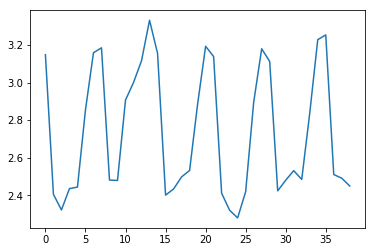

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.801574   
air_0164b9927d20bcc3_2017-04-23              1.353640   
air_0241aa3964b7f861_2017-04-23              2.332076   
air_0328696196e46f18_2017-04-23              2.101782   
air_034a3d5b40d5b1b1_2017-04-23              3.495269   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.059178  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.871492  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.299305  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.180732  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.959147

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l4_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')